# AMS 526 Homework 4 
**submitted by Jiaxi Zhao on 25th Oct, 2020**

In this report, we first implement a simple version of QR iteration with shifts for computing the eigenvalues of a general real matrix $A$. Then, we use Rayleigh quotient iteration and take the estimate eigenvalues as initial value to calculate the eigenvectors corresponding to these eigenvalues. Numerical experiments are conducted to compare this implementation with the built-in function in Python to calculate eigenvalues and eigenvectors.


In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from time import time
from scipy.linalg import lu as lu
import scipy.linalg as alg
from scipy.linalg import solve_triangular as st
from scipy.linalg import solve as ss

## Overview of the procedure to calculate the eigenvalues of matrices using QR iteration with shifts and then obtain the corresponding eigenvectors using Rayleigh quotient iteration

### Implementation of a simple version of QR iteration with shifts and Rayleigh quotient iteration
In this section, we briefly review the QR iteration with shifts and Rayleigh quotient iteration.

A simple version for QR iteration with shifts that we will implement is provided below
\begin{itemize}
    \item Repeated the following procedure until stop criterion (convergence).
    \item $\mu = A[n, n]$ (use corner entry as shift).
    \item Compute the QR-factorization of the shifted matrix $A - \mu I = QR$.
    \item $A = RQ + \mu I$.
\end{itemize}
The calculation iteration of a specific eigenvalue will stop if all the off-diagonal terms that are at the same column or row as this eigenvalue are close to $0$ (with error $\epsilon$ closes to the machine epsilon, here, we artificially set it as $10^{-14}$). And then we start the next iteration to calculate the next eigenvalue by shrinking the dimension of the matrix $A$ by $1$.

After obtain estimations of eigenvalues using QR iteration with shifts, we turn to use Rayleigh quotient iteration to calculate the eigenvectors associated with these eigenvalues. This algorithm is summarized as follows:
\begin{itemize}
    \item Repeated the following procedure until stop criterion (convergence).
    \item Solve the linear system $\left( A - rI \right)^{-1} w = v$ for $w$.
    \item Normalize $w$ to $w := \frac{w}{\left\| w \right\|_2}$.
    \item Calculate the Rayleigh quotient $r = w^T A w$.
\end{itemize}
The initial value of the Rayleigh quotient parameter $r$ is set to be the estimated eigenvalue from prevoius procedure. And this algorithm is well-known to have cubic convergence rate.
   

In [2]:
tol = 1E-14
def sgn(x):
    # Modified sign function
    if x == 0:
        return 1
    else:
        return np.sign(x)

def QR_shift(A):
    # QR iteration with shifts, a simple version without the phase 1 pre-condition. In each while loop, exactly 
    # one eigenvalue is calculated using QR iteration with shifts A[n-j, n-j]. Deflation is used to shrink the 
    # matrix after each while iteration.
    [n, m]           = A.shape
    for j in range(1, n):
        I           = np.eye(n - j + 1)
        #l           = 1
        while True:
            #print('iter num: ', l)
            mu      = A[n - j, n - j]
            A_s     = (A[0:n - j + 1, 0:n - j + 1] - mu * I).copy()
            [Q, R]  = alg.qr(A_s)
            A[0:n - j + 1, 0:n - j + 1] = (R.dot(Q) + mu * I).copy()
            for i in range(n - j):
                if np.abs(A[i, n - j]) < tol or np.abs(A[n - j, i]) < tol:
                    A[i, n - j] = 0
                    A[n - j, i] = 0
            res     = 0
            #l       = l + 1
            for i in range(n - j):
                res = res + np.abs(A[i, n - j]) + np.abs(A[n - j, i])
            if res < tol:
            # The last eigen value 
                break 
            
              
    #print(A)
    return np.diag(A)

def RQ_iter(A, eig):
    # Rayleigh quotient iteration with an initial estimate of the eigenvalue given by previous QR iteration with
    # shift
    [n, m]  = A.shape
    I       = np.eye(n)
    V       = np.zeros([n, n])
    for i in range(n):
        r       = eig[i] + tol * np.random.rand()
        v       = np.zeros(n)
        v_n     = np.ones(n)
        #j       = 1
        while alg.norm(v - v_n, 1) > tol:
            #print('iter num: ', j)
            #print(alg.norm(v - v_n, 1))
            v   = v_n
            v_n = ss(A - r * I, v)
            v_n = v_n / alg.norm(v_n, 2)
            v_n = v_n * sgn(v_n[0])
            r   = v_n.dot(A.dot(v_n))
            #j   = j + 1
        V[:, i] = v_n

    return V


In [3]:
A   = np.random.randn(5, 5)
A   = (A + A.T).copy()
B   = A.copy()
eig = QR_shift(B)
print("Eigenvalues calculated by our implementation: ")
print(QR_shift(B))
print("Eigenvalues calculated by Python built-in implementation: ")
print(alg.eigvals(A))
V   = RQ_iter(A, eig)
print(V)
print(V.dot(V.T))

Eigenvalues calculated by our implementation: 
[-5.41991244  3.25943508  0.78090531 -0.96802885 -2.62791127]
Eigenvalues calculated by Python built-in implementation: 
[-5.41991244+0.j  3.25943508+0.j -2.62791127+0.j -0.96802885+0.j
  0.78090531+0.j]
[[ 0.21039312  0.0579976   0.02410251  0.12338805  0.96776313]
 [-0.06709774  0.55832193 -0.32806249 -0.75421896  0.08545924]
 [ 0.27064495  0.59404113  0.74337373  0.07839423 -0.12294834]
 [ 0.5894142  -0.52457344  0.25798322 -0.5566184  -0.03215939]
 [ 0.72840569  0.23843395 -0.52214388  0.31616365 -0.1999518 ]]
[[ 1.00000000e+00 -3.23166636e-18 -4.61006968e-18 -1.52178537e-17
  -6.51647066e-17]
 [-3.23166636e-18  1.00000000e+00 -5.45104572e-17  1.34778177e-16
  -6.16618929e-18]
 [-4.61006968e-18 -5.45104572e-17  1.00000000e+00 -2.29480518e-16
  -3.99970781e-17]
 [-1.52178537e-17  1.34778177e-16 -2.29480518e-16  1.00000000e+00
  -1.64282880e-17]
 [-6.51647066e-17 -6.16618929e-18 -3.99970781e-17 -1.64282880e-17
   1.00000000e+00]]


/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=3.0504e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=9.38885e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.88029e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.51532e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.08878e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launch

## Numerical experiment on polynomial fitting
### Accuracy of implemented algorithm and built-in algorithm
In this section, we test our algorithm in two artificially constructed matrices $A, B$ and compare the accuracy of our results with those obtained via built-in function in Python. You can test the algorithms on different matrix by slightly modifying the code.

In [4]:
A       = np.array([[2, 3, 2], [10, 3, 4], [3, 6, 1]], dtype = 'float64')
#A       = np.array([[6, 2, 1], [2,  3, 1], [1, 1, 1]], dtype = 'float64');
[n, m]  = A.shape
B       = A.copy()
eig_my  = QR_shift(B)
eig_py  = alg.eigvals(A)
# We have to sort two sequences of eigenvalues
eig_my  = np.sort(eig_my)
eig_py  = np.sort(eig_py)
print("Eigenvalues calculated by our implementation: ")
print(eig_my)
print("Eigenvalues calculated by Python built-in implementation: ")
print(eig_py)
print("L_1 error of eigenvalues: ")
print(alg.norm(eig_py - eig_my, 1))

V_py    = alg.eig(A, left = False, right = True)[1]
V_my    = RQ_iter(A, eig_my)
# First, we have to make the sign for eigenvectors in two implementations consistent in order to compare their
# accuracy
for i in range(n):
    for j in range(n):
        if np.abs(V_my[j, i]) > tol and sgn(V_my[j, i]) != 1:
            V_my[:, i] = -V_my[:, i]          
for i in range(n):
    for j in range(n):
        if np.abs(V_py[j, i]) > tol and sgn(V_py[j, i]) != 1:
            V_py[:, i] = -V_py[:, i]           
# Next, we have to sort two sequences of eigenvalues
V_my    = V_my[:, V_my[0].argsort()]
V_py    = V_py[:, V_py[0].argsort()]
print("Eigenvectors calculated by our implementation: ")
print(V_my)
print("Eigenvectors calculated by Python built-in implementation: ")
print(V_py)
print("L_1 error of eigenvectors: ")
print(alg.norm(V_my - V_py, 1))


Eigenvalues calculated by our implementation: 
[-3. -2. 11.]
Eigenvalues calculated by Python built-in implementation: 
[-3.+0.j -2.+0.j 11.+0.j]
L_1 error of eigenvalues: 
7.993605777301127e-15
Eigenvectors calculated by our implementation: 
[[-1.82574186e-01 -2.70628139e-17  3.71390676e-01]
 [-3.65148372e-01 -5.54700196e-01  7.42781353e-01]
 [ 9.12870929e-01  8.32050294e-01  5.57086015e-01]]
Eigenvectors calculated by Python built-in implementation: 
[[-1.82574186e-01  2.17732649e-17  3.71390676e-01]
 [-3.65148372e-01 -5.54700196e-01  7.42781353e-01]
 [ 9.12870929e-01  8.32050294e-01  5.57086015e-01]]
L_1 error of eigenvectors: 
3.3306690738754696e-16


/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.97373e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=9.86865e-18): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=4.73251e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=5.80509e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=7.53606e-17): result may not be accurate.


\begin{remark}
    One comment on realizing the numerical experiments is that for the first matrix, since the eigenvalues of this matrix are all integers, resulting in high precision of our QR iteration with shifts. Then, when we use Rayleigh quotient iteration, this will cause the matrix $A - \mu I$ to be singular, breaking down the whole procedure. This phenomenon will not happen in the case for general matrix, whose eigenvalues are usually floating point. The round-off error for computer will prevent the matrix $A - \mu I$ from being singular and validate the whole algorithm. To resolve this dilemma, we borrow the idea of stochastic gradient descent (SGD) from optimization community which introduces random noise to improve the performance of the algorithm. Similarly, we add a random noise of small order to our Rayleigh quotient iteration algorithm, namely the step to initialize the quotient parameter to be the estimated eigenvalue we have once calculated. It turns out that this improvement completely solve the problem and also retain the preformance on general matrices. 
\end{remark}

In [5]:
# For large scale matrix, we have to slightly increase the tolerance error in order the algorithm terminates.
tol     = 1E-13
A       = np.random.randn(50, 50)
A       = (A + A.T).copy()
[n, m]  = A.shape
B       = A.copy()
eig_my  = QR_shift(B)
eig_py  = alg.eigvals(A)
# We have to sort two sequences of eigenvalues
eig_my  = np.sort(eig_my)
eig_py  = np.sort(eig_py)
#print("Eigenvalues calculated by our implementation: ")
#print(eig_my)
#print("Eigenvalues calculated by Python built-in implementation: ")
#print(eig_py)
print("L_1 error for eigenvalues: ")
print(alg.norm(eig_py - eig_my, 1))

V_py    = alg.eig(A, left = False, right = True)[1]
V_my    = RQ_iter(A, eig_my)
# First, we have to make the sign for eigenvectors in two implementations consistent in order to compare their
# accuracy
for i in range(n):
    for j in range(n):
        if np.abs(V_my[j, i]) > tol and sgn(V_my[j, i]) != 1:
            V_my[:, i] = -V_my[:, i]          
for i in range(n):
    for j in range(n):
        if np.abs(V_py[j, i]) > tol and sgn(V_py[j, i]) != 1:
            V_py[:, i] = -V_py[:, i]           
# Next, we have to sort two sequences of eigenvalues
V_my    = V_my[:, V_my[0].argsort()]
V_py    = V_py[:, V_py[0].argsort()]
print("L_1 error for eigenvectors: ")
print(alg.norm(V_my - V_py, 1))

L_1 error for eigenvalues: 
1.0952905249439482e-12
L_1 error for eigenvectors: 
3.8598594806482645e-13


/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=2.39878e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.57719e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=6.76946e-18): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=1.90397e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=8.56552e-18): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launc

### Convergence analysis of QR iteration with shifts and Rayleigh quotient iteration
In this last section, we conduct extra numerical experiments to study the performance of QR iteration with shifts and Rayleigh quotient iteration separately and calculate their convergence rate. We start with the study of QR iteration with shifts.
#### Convergence analysis of QR iteration with shifts

In [6]:
iter_num = 100
tol      = 1E-12
def QR_shift_conv(A):
    # QR iteration with shifts, a simple version without the phase 1 pre-condition. In each while loop, exactly 
    # one eigenvalue is calculated using QR iteration with shifts A[n-j, n-j]. Deflation is used to shrink the
    # matrix after each while iteration.
    [n, m]          = A.shape
    my_eigen        = np.zeros([n, iter_num])
    for j in range(1, n):
        I           = np.eye(n - j + 1)
        l           = 2
        while True:
            mu      = A[n - j, n - j]
            my_eigen[j, l] = mu
            A_s     = (A[0:n - j + 1, 0:n - j + 1] - mu * I).copy()
            [Q, R]  = alg.qr(A_s)
            A[0:n - j + 1, 0:n - j + 1] = (R.dot(Q) + mu * I).copy()
            for i in range(n - j):
                if np.abs(A[i, n - j]) < tol or np.abs(A[n - j, i]) < tol:
                    A[i, n - j] = 0
                    A[n - j, i] = 0
            res     = 0
            for i in range(n - j):
                res = res + np.abs(A[i, n - j]) #+ np.abs(A[n - j, i])
            if res < tol:
            # The last eigen value 
                break
            l       = l + 1
        my_eigen[j, 1] = my_eigen[j, l]
        my_eigen[j, 0] = l
    my_eigen[0, 1] = A[0, 0]
    my_eigen[0, 2] = A[0, 0]
    my_eigen[0, 0] = 2
    
    #print(A)
    return my_eigen

In [9]:
A       = np.random.randn(50, 50)
A       = (A + A.T).copy()
[n, m]  = A.shape
B       = A.copy() 
eig_py  = alg.eigvals(A)
eig_my  = QR_shift_conv(B)
# We have to sort two sequences of eigenvalues
eig_my  = eig_my[eig_my[:, 1].argsort()]
eig_py  = np.sort(eig_py)
for j in range(n):
    plt.plot(np.log10(np.abs(eig_py[j] - eig_my[j, 2:int(eig_my[j, 0] + 1)])))
    plt.xlabel('# of iteration')
    plt.ylabel('Log10-error of each eigenvalue')
    plt.title('Convergence rate of QR iteration with shifts')
    plt.rcParams[‘savefig.dpi’] = 300 # 图片像素
    plt.rcParams[‘figure.dpi’] = 300 # 分辨率

plt.savefig('./test2.jpg')
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-9-647b636bed5e>, line 15)

\begin{remark}
    It can be concluded from the above figure that most of the QR iterations with shifts end up with no more than $5$ iterations and display a great convergence rate.
\end{remark}

#### Convergence analysis of Rayleigh quotient iteration

In [334]:
iter_num = 100
tol      = 1E-12
def RQ_iter_conv(A, eig, eigvect):
    # Rayleigh quotient iteration with an initial estimate of the eigenvalue given by previous QR iteration with
    # shift
    [n, m]  = A.shape
    I       = np.eye(n)
    V       = np.zeros([n, n])
    my_eigen = np.zeros([n, iter_num])
    for i in range(n):
        eigv_i  = eigvect[:, i]
        error   = np.zeros(iter_num)
        l       = 2
        r       = eig[i] + tol * np.random.rand()
        v       = np.zeros(n)
        v_n     = np.ones(n)
        j       = 0
        while alg.norm(v - v_n, 1) > tol:
            #print('iter num: ', j)
            my_eigen[i, l] = r
            v   = v_n
            error[j] = alg.norm(v - sgn(v[0]) * sgn(eigv_i[0]) * eigv_i, 1)
            v_n = ss(A - r * I, v)
            v_n = v_n / alg.norm(v_n, 2)
            v_n = v_n * sgn(v_n[0])
            r   = v_n.dot(A.dot(v_n))
            j   = j + 1
            l   = l + 1
        V[:, i] = v_n
        my_eigen[i, 0] = l
        my_eigen[i, 1] = my_eigen[i, l - 1]
        plt.plot(np.log10(error[0:j]))
        
    plt.xlabel('# of iteration')
    plt.ylabel('Log10-error of each eigenvector')
    plt.title('Convergence rate of Rayleigh quotient iteration')

    return my_eigen

/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:23: LinAlgWarning: Ill-conditioned matrix (rcond=9.92827e-18): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:23: LinAlgWarning: Ill-conditioned matrix (rcond=6.28998e-18): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:23: LinAlgWarning: Ill-conditioned matrix (rcond=1.53858e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:23: LinAlgWarning: Ill-conditioned matrix (rcond=4.83343e-18): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launcher.py:23: LinAlgWarning: Ill-conditioned matrix (rcond=1.07319e-17): result may not be accurate.
/Users/zhaojiaxi/anaconda3/envs/Applymath/lib/python3.6/site-packages/ipykernel_launc

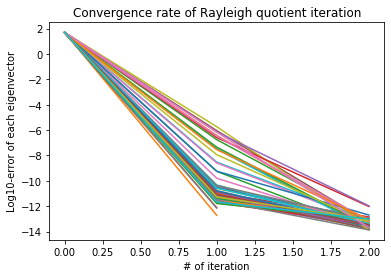

In [340]:
A       = np.random.randn(50, 50)
A       = (A + A.T).copy()
[n, m]  = A.shape
B       = A.copy()

eig_py  = alg.eigvals(A)
V_py    = alg.eig(A, left = False, right = True)[1]
eig_My  = QR_shift_conv(B)
# We have to sort two sequences of eigenvalues and eigenvectors
eig_My  = eig_My[eig_My[:, 1].argsort()]
V_py    = V_py[:, eig_py.argsort()]
eig_py  = np.sort(eig_py)
eig_my  = RQ_iter_conv(A, eig_My[:, 1], V_py)

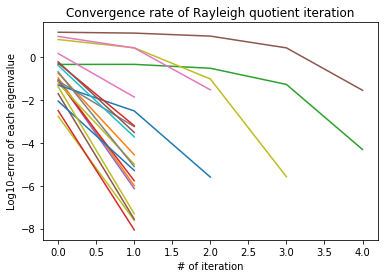

In [342]:
for j in range(n):
    #plt.plot(eig_my[j, 2:int(eig_my[j, 0] + 1)])
    plt.plot(np.log10(np.abs(eig_py[j] - eig_My[j, 2:int(eig_My[j, 0])])))
    plt.xlabel('# of iteration')
    plt.ylabel('Log10-error of each eigenvalue')
    plt.title('Convergence rate of Rayleigh quotient iteration')

\begin{remark}
    In this extended experiment, we find that in each Rayleigh quotient iteration, only about 2 iterations will provide us with a solution to the eigenvector which is precise enough.
\end{remark}